In [2]:
import sys, os, time
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint
import gym
import h5py as hf

%load_ext autoreload
%autoreload 2

import foundation as fd
from foundation import util
from foundation import nets
from foundation import train

from nb_backend import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100

niters = 100
lr = 1e-2
device =torch.device('cuda:0') if torch.cuda.is_available() else 'cpu' #'cpu' #torch.device('cuda:0')

In [12]:
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
        nspiral=nspiral,
        start=start,
        stop=stop,
        noise_std=noise_std,
        a=a, b=b,
        savefig=False
    )
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)
orig_trajs.shape, samp_trajs.shape, samp_ts.shape

(torch.Size([1000, 500, 2]), torch.Size([1000, 100, 2]), torch.Size([100]))

<IPython.core.display.Javascript object>


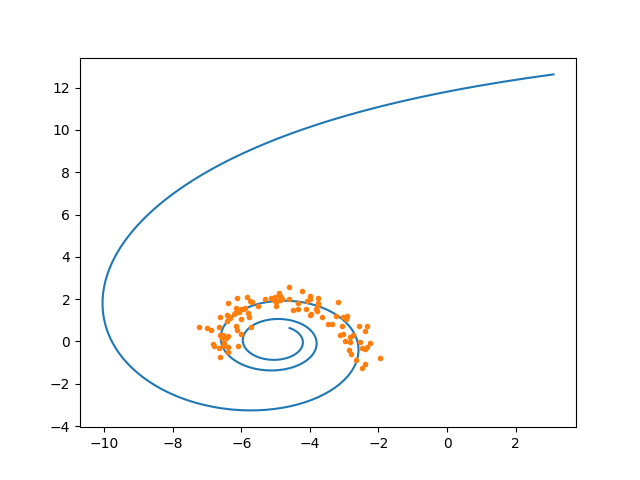

In [13]:
plt.figure()
idx = 12
plt.plot(*orig_trajs[idx].cpu().numpy().T)
plt.plot(*samp_trajs[idx].cpu().numpy().T, ls='', marker='.')

In [14]:
samp_ts

tensor([0.0000, 0.0378, 0.0755, 0.1133, 0.1511, 0.1889, 0.2266, 0.2644, 0.3022,
        0.3400, 0.3777, 0.4155, 0.4533, 0.4911, 0.5288, 0.5666, 0.6044, 0.6422,
        0.6799, 0.7177, 0.7555, 0.7933, 0.8310, 0.8688, 0.9066, 0.9444, 0.9821,
        1.0199, 1.0577, 1.0955, 1.1332, 1.1710, 1.2088, 1.2466, 1.2843, 1.3221,
        1.3599, 1.3977, 1.4354, 1.4732, 1.5110, 1.5488, 1.5865, 1.6243, 1.6621,
        1.6999, 1.7376, 1.7754, 1.8132, 1.8510, 1.8887, 1.9265, 1.9643, 2.0021,
        2.0398, 2.0776, 2.1154, 2.1532, 2.1909, 2.2287, 2.2665, 2.3043, 2.3420,
        2.3798, 2.4176, 2.4554, 2.4931, 2.5309, 2.5687, 2.6065, 2.6442, 2.6820,
        2.7198, 2.7576, 2.7953, 2.8331, 2.8709, 2.9086, 2.9464, 2.9842, 3.0220,
        3.0597, 3.0975, 3.1353, 3.1731, 3.2108, 3.2486, 3.2864, 3.3242, 3.3619,
        3.3997, 3.4375, 3.4753, 3.5130, 3.5508, 3.5886, 3.6264, 3.6641, 3.7019,
        3.7397], device='cuda:0')

In [15]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
print(func)
print(rec)
print(dec)
cnt = list(map(util.count_parameters, [func, rec, dec]))
print(cnt, sum(cnt))

LatentODEfunc(
  (elu): ELU(alpha=1.0, inplace)
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=4, bias=True)
)
RecognitionRNN(
  (i2h): Linear(in_features=27, out_features=25, bias=True)
  (h2o): Linear(in_features=25, out_features=8, bias=True)
)
Decoder(
  (relu): ReLU(inplace)
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)
[604, 908, 142] 1654


In [16]:
itr = 0

In [18]:
for _ in range(1000):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # compute loss
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    noise_logvar = 2. * torch.log(noise_std_).to(device)
    logpx = log_normal_pdf(
        samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                            pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())

    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

    itr += 1

Iter: 1000, running avg elbo: -1967.8515
Iter: 1001, running avg elbo: -1959.6964
Iter: 1002, running avg elbo: -1951.2711
Iter: 1003, running avg elbo: -1942.7242
Iter: 1004, running avg elbo: -1934.0567
Iter: 1005, running avg elbo: -1925.2086
Iter: 1006, running avg elbo: -1916.2664
Iter: 1007, running avg elbo: -1907.4794
Iter: 1008, running avg elbo: -1898.6243
Iter: 1009, running avg elbo: -1889.7708
Iter: 1010, running avg elbo: -1880.9601
Iter: 1011, running avg elbo: -1871.9482
Iter: 1012, running avg elbo: -1862.9044
Iter: 1013, running avg elbo: -1854.0602
Iter: 1014, running avg elbo: -1844.9605
Iter: 1015, running avg elbo: -1835.9415
Iter: 1016, running avg elbo: -1826.8693
Iter: 1017, running avg elbo: -1817.7955
Iter: 1018, running avg elbo: -1808.6456
Iter: 1019, running avg elbo: -1799.6723
Iter: 1020, running avg elbo: -1790.3805
Iter: 1021, running avg elbo: -1781.1160
Iter: 1022, running avg elbo: -1771.7642
Iter: 1023, running avg elbo: -1762.5189
Iter: 1024, runn

Iter: 1202, running avg elbo: -643.3775
Iter: 1203, running avg elbo: -640.6877
Iter: 1204, running avg elbo: -637.2216
Iter: 1205, running avg elbo: -634.5732
Iter: 1206, running avg elbo: -631.3276
Iter: 1207, running avg elbo: -628.3351
Iter: 1208, running avg elbo: -625.3172
Iter: 1209, running avg elbo: -622.1535
Iter: 1210, running avg elbo: -619.1483
Iter: 1211, running avg elbo: -616.0757
Iter: 1212, running avg elbo: -612.8990
Iter: 1213, running avg elbo: -609.8113
Iter: 1214, running avg elbo: -606.5637
Iter: 1215, running avg elbo: -603.4587
Iter: 1216, running avg elbo: -600.2876
Iter: 1217, running avg elbo: -597.4474
Iter: 1218, running avg elbo: -594.3605
Iter: 1219, running avg elbo: -591.5119
Iter: 1220, running avg elbo: -588.5235
Iter: 1221, running avg elbo: -585.5080
Iter: 1222, running avg elbo: -582.6115
Iter: 1223, running avg elbo: -579.7700
Iter: 1224, running avg elbo: -576.9295
Iter: 1225, running avg elbo: -574.1963
Iter: 1226, running avg elbo: -571.2481


Iter: 1407, running avg elbo: -315.7524
Iter: 1408, running avg elbo: -314.8709
Iter: 1409, running avg elbo: -314.3309
Iter: 1410, running avg elbo: -313.4522
Iter: 1411, running avg elbo: -312.8184
Iter: 1412, running avg elbo: -312.0914
Iter: 1413, running avg elbo: -311.1849
Iter: 1414, running avg elbo: -310.4796
Iter: 1415, running avg elbo: -309.6288
Iter: 1416, running avg elbo: -308.7078
Iter: 1417, running avg elbo: -307.9078
Iter: 1418, running avg elbo: -307.0339
Iter: 1419, running avg elbo: -306.1420
Iter: 1420, running avg elbo: -305.2394
Iter: 1421, running avg elbo: -304.3103
Iter: 1422, running avg elbo: -303.4809
Iter: 1423, running avg elbo: -302.5663
Iter: 1424, running avg elbo: -301.6672
Iter: 1425, running avg elbo: -300.8243
Iter: 1426, running avg elbo: -300.0269
Iter: 1427, running avg elbo: -299.2283
Iter: 1428, running avg elbo: -298.4769
Iter: 1429, running avg elbo: -297.7691
Iter: 1430, running avg elbo: -297.0896
Iter: 1431, running avg elbo: -296.4794


Iter: 1612, running avg elbo: -204.3537
Iter: 1613, running avg elbo: -204.0166
Iter: 1614, running avg elbo: -203.7216
Iter: 1615, running avg elbo: -203.4202
Iter: 1616, running avg elbo: -203.0742
Iter: 1617, running avg elbo: -202.7459
Iter: 1618, running avg elbo: -202.4363
Iter: 1619, running avg elbo: -202.0840
Iter: 1620, running avg elbo: -201.7695
Iter: 1621, running avg elbo: -201.4389
Iter: 1622, running avg elbo: -201.1259
Iter: 1623, running avg elbo: -200.8195
Iter: 1624, running avg elbo: -200.4901
Iter: 1625, running avg elbo: -200.2139
Iter: 1626, running avg elbo: -199.9182
Iter: 1627, running avg elbo: -199.6145
Iter: 1628, running avg elbo: -199.3562
Iter: 1629, running avg elbo: -199.1483
Iter: 1630, running avg elbo: -198.8493
Iter: 1631, running avg elbo: -198.5463
Iter: 1632, running avg elbo: -198.3111
Iter: 1633, running avg elbo: -197.9988
Iter: 1634, running avg elbo: -197.7153
Iter: 1635, running avg elbo: -197.4698
Iter: 1636, running avg elbo: -197.1410


Iter: 1817, running avg elbo: -163.5413
Iter: 1818, running avg elbo: -163.3738
Iter: 1819, running avg elbo: -163.1815
Iter: 1820, running avg elbo: -163.0147
Iter: 1821, running avg elbo: -162.8571
Iter: 1822, running avg elbo: -162.7022
Iter: 1823, running avg elbo: -162.6061
Iter: 1824, running avg elbo: -162.5498
Iter: 1825, running avg elbo: -162.5660
Iter: 1826, running avg elbo: -162.6734
Iter: 1827, running avg elbo: -162.7346
Iter: 1828, running avg elbo: -162.6488
Iter: 1829, running avg elbo: -162.4879
Iter: 1830, running avg elbo: -162.3492
Iter: 1831, running avg elbo: -162.2618
Iter: 1832, running avg elbo: -162.3474
Iter: 1833, running avg elbo: -162.4859
Iter: 1834, running avg elbo: -162.6638
Iter: 1835, running avg elbo: -162.6509
Iter: 1836, running avg elbo: -162.4678
Iter: 1837, running avg elbo: -162.3523
Iter: 1838, running avg elbo: -162.4372
Iter: 1839, running avg elbo: -162.8240
Iter: 1840, running avg elbo: -163.2509
Iter: 1841, running avg elbo: -163.5773


<IPython.core.display.Javascript object>


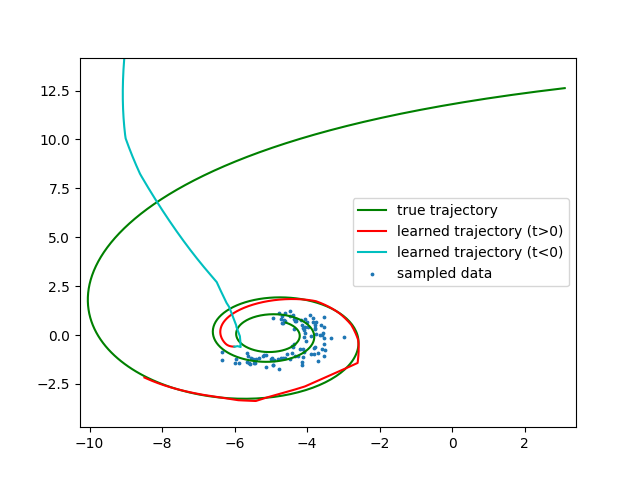

In [25]:
with torch.no_grad():
    # sample from trajectorys' approx. posterior
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    orig_ts = torch.from_numpy(orig_ts).float().to(device)

    # take first trajectory for visualization
    z0 = z0[10]

    ts_pos = np.linspace(0., 2. * np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)

    zs_pos = odeint(func, z0, ts_pos)
    zs_neg = odeint(func, z0, ts_neg)

    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

orig_ts = orig_ts.cpu().numpy()
    
xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = orig_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1],
         'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
         label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
         label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[
            :, 1], label='sampled data', s=3)
plt.legend()
#plt.savefig('./vis.png', dpi=500)
#print('Saved visualization figure at {}'.format('./vis.png'))


In [67]:
h = rec.initHidden().to(device)
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]

In [98]:
analytic_kl.shape

torch.Size([1000])

<IPython.core.display.Javascript object>


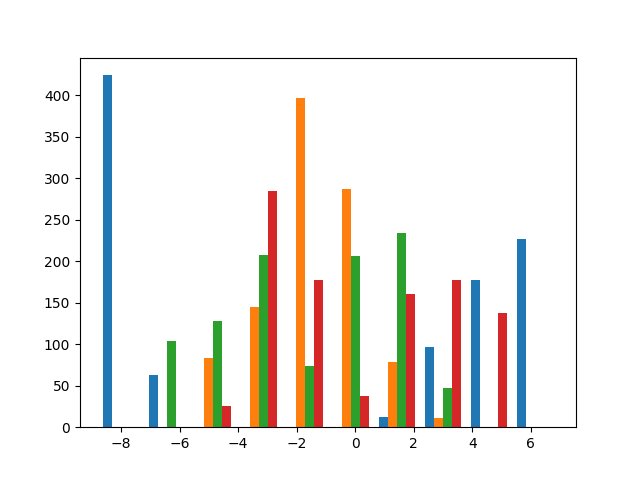

([array([424.,  63.,   0.,   0.,   0.,   0.,  12.,  97., 177., 227.]),
  array([  0.,   0.,  83., 145., 396., 287.,  78.,  11.,   0.,   0.]),
  array([  0., 104., 128., 207.,  74., 206., 234.,  47.,   0.,   0.]),
  array([  0.,   0.,  25., 285., 177.,  38., 160., 177., 138.,   0.])],
 array([-8.791216  , -7.2189283 , -5.646641  , -4.0743527 , -2.5020652 ,
        -0.9297776 ,  0.64251006,  2.2147977 ,  3.7870853 ,  5.359373  ,
         6.9316607 ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

In [99]:
plt.figure()
plt.hist(z0.detach().cpu().numpy())

In [100]:
sample = torch.randn(10, 4).to(device)

In [101]:
z = odeint(func, sample, samp_ts).permute(1, 0, 2)
x = dec(z)
z.shape, x.shape

(torch.Size([10, 100, 4]), torch.Size([10, 100, 2]))

<IPython.core.display.Javascript object>


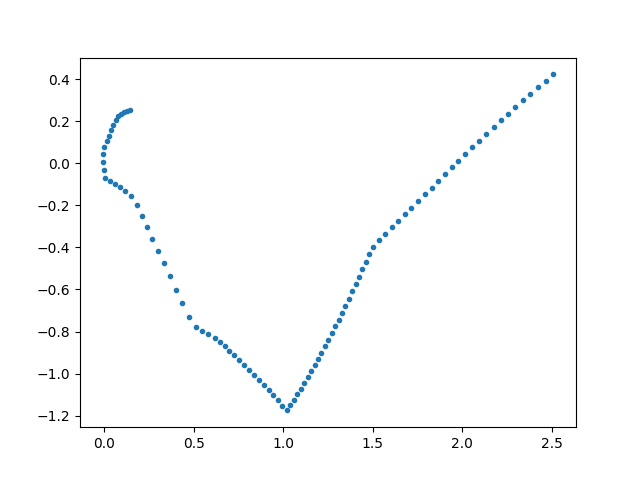

In [103]:
plt.figure()
idx = 4
plt.plot(*x[idx].detach().cpu().numpy().T, ls='', marker='.')